In [22]:
from Entities.database import HiscoreDf
from Entities.helpers import (Advanced_DF_Skill_Ratio, Advanced_DF_Levels, undersample)
from Entities.database.SkillAgg import get_skill_aggregate_hiscore

activity = 'Firemaking'
df, formatter = get_skill_aggregate_hiscore(activity, LIMIT=2500)

df = Advanced_DF_Levels(df)
df.describe(include='bool')
df

,pid,Banned,updates,activescrapes,inactivescrapes,shortestinactivity,shortestactivity,longestinactivity,longestactivity,Overall_live,...,Vardorvis_aggregate,Venenatis_aggregate,Vet'ion_aggregate,Vorkath_aggregate,Wintertodt_aggregate,Zalcano_aggregate,Zulrah_aggregate,Colosseum Glory_aggregate,Deadman Points_aggregate,League Points_aggregate
0,170698,False,37,28,9,1,1,6,9,2236452139,...,0.0,8.0,0.0,4115.0,6342.0,251.0,3117.0,0,0,0
1,80833,False,71,67,4,1,3,2,53,601621625,...,0.0,0.0,0.0,0.0,5752.0,0.0,0.0,0,0,0
2,3804178,True,19,4,15,7,1,8,1,171624284,...,0.0,0.0,0.0,0.0,577.0,0.0,0.0,0,0,0
3,682311,True,45,40,5,5,0,5,0,252826786,...,0.0,0.0,0.0,0.0,6254.0,0.0,0.0,0,0,0
4,1096481,False,71,70,1,1,0,1,0,687382853,...,0.0,0.0,0.0,0.0,3588.0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,339693,False,57,21,36,1,1,11,11,177086291,...,0.0,0.0,0.0,0.0,83.0,0.0,0.0,0,0,0
2496,105584,False,72,67,5,2,1,3,1,319339186,...,0.0,2.0,0.0,0.0,101.0,0.0,0.0,0,0,0
2497,182610,False,72,65,7,1,1,1,23,216491210,...,0.0,0.0,0.0,84.0,287.0,50.0,0.0,0,0,0
2498,75002,False,72,71,1,1,0,1,0,427903760,...,0.0,0.0,0.0,0.0,53.0,0.0,0.0,0,0,0


# Performance

The PCA not including minigames has a higher recall for Banned class

In [23]:
UNDERSAMPLE = True

if UNDERSAMPLE:
    undersampled_df = undersample(df)
    class_weights = None
else:
    banned_count = len(df[df['Banned'] == True])
    unbanned_count = len(df[df['Banned'] == False])

    class_weights = {0: unbanned_count, 1: banned_count}

Undersampling complete: 2500 into 636 rows.
Class size: 318


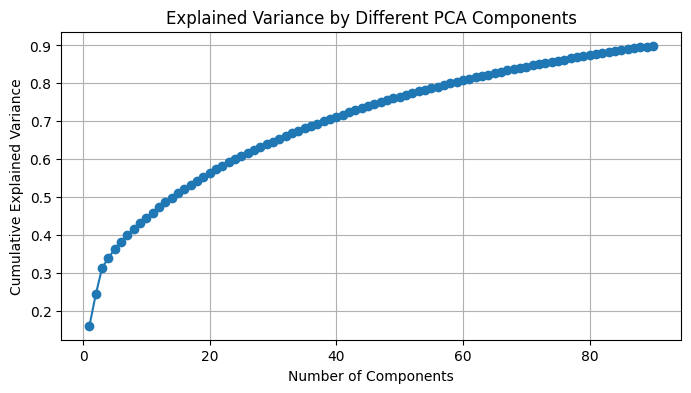

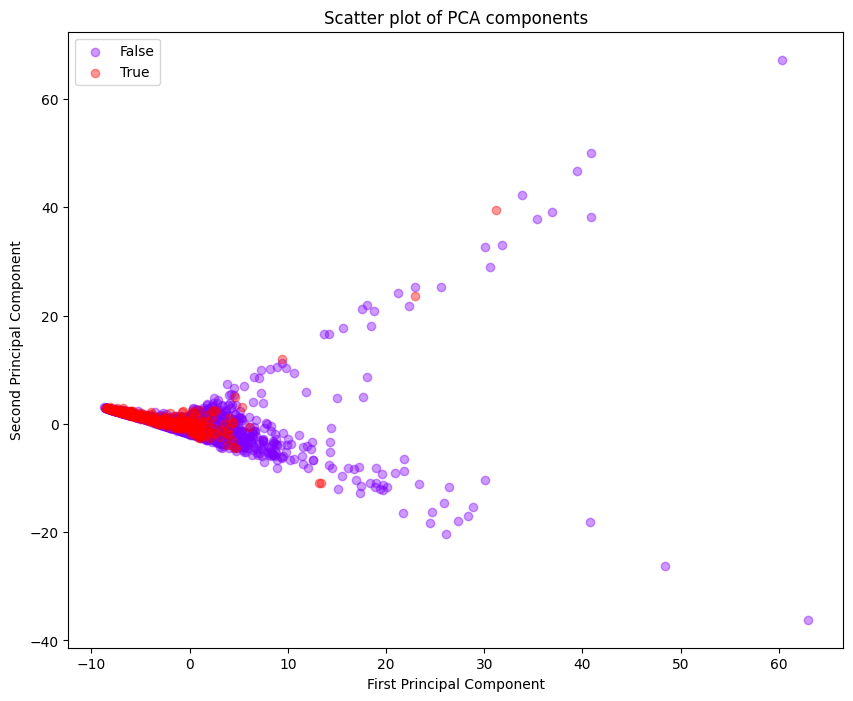

In [24]:
from Entities.features.PcaAgg import PcaAgg


pca = PcaAgg(df=df,
            skills=formatter.live_skills,
            skills_agg=formatter.agg_skills,
            minigames=formatter.live_minigames,
            minigames_agg=formatter.agg_minigames,
             extra_features = formatter.extra_features,
            n_components=90)
pca.run()
pca.elbow_plot()
pca.plot()

In [25]:
from Entities.Models import rf_model

rf_model(pca.X_r, pca.y, class_weights,n_estimators=100, threshold=0.3, use_cross_val=True)

Weights: None
Accuracy: 0.84
Confusion Matrix:
 [[1940  242]
 [ 163  155]]
Classification Report:
               precision    recall  f1-score   support

       False       0.92      0.89      0.91      2182
        True       0.39      0.49      0.43       318

    accuracy                           0.84      2500
   macro avg       0.66      0.69      0.67      2500
weighted avg       0.85      0.84      0.85      2500

ROC-AUC Score: 0.83


In [26]:
from Entities.Models import et_model

et_model(pca.X_r, pca.y, class_weights,n_estimators=100, threshold=0.5, use_cross_val=True)

Weights: None
Accuracy: 0.87
Confusion Matrix:
 [[2144   38]
 [ 281   37]]
Classification Report:
               precision    recall  f1-score   support

       False       0.88      0.98      0.93      2182
        True       0.49      0.12      0.19       318

    accuracy                           0.87      2500
   macro avg       0.69      0.55      0.56      2500
weighted avg       0.83      0.87      0.84      2500

ROC-AUC Score: 0.83


In [27]:
pca_df = pca.plot_interactive(activity)

# Further analysis of the accounts that are in high ban density areas

- By finding the range of the PCA values you can fetch a list of players
- With the player list we can use our HiscoreDf Class to visualize the Skills of the players in this area

In [28]:
# High ban density area
X1, X2 = -9, -2
Y1, Y2 = -2, 3.5
pca.plot_interactive(activity, x_range=(X1, X2), y_range=(Y1, Y2))
# Apply conditions to filter the DataFrame
filtered_df = pca_df[(pca_df['PC1'] >= X1) & (pca_df['PC1'] <= X2) & (pca_df['PC2'] >= Y1) & (pca_df['PC2'] <= Y2)]

pids = filtered_df['pid'].tolist()

In [29]:
hiscore_df = HiscoreDf(pids)

hiscore_df = hiscore_df.set_index('pid')
hiscore_df.insert(0, 'Banned', filtered_df[['pid', 'Banned']].set_index('pid')['Banned'])
hiscore_df.reset_index(inplace=True)


hiscore_df

,pid,Banned,Name,Overall,Attack,Defence,Strength,Hitpoints,Ranged,Prayer,...,Vardorvis,Venenatis,Vet'ion,Vorkath,Wintertodt,Zalcano,Zulrah,Colosseum Glory,Deadman Points,League Points
0,535157,False,AlecTV,69.15M,82,81,90,86,83,72,...,0,0,0,0,606,0,0,0,0,0
1,535621,False,SwitchYDC,122.30M,70,65,76,72,70,99,...,0,0,0,0,426,0,0,0,0,0
2,541919,False,PLEASE COlN,138.90M,101,99,100,106,104,77,...,0,0,0,1145,323,0,104,0,0,0
3,582319,False,Mr7oda,119.58M,99,99,100,102,100,81,...,0,241,0,308,502,0,11,0,0,0
4,584052,False,Cummins920,66.73M,80,79,86,83,80,99,...,0,0,0,0,509,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,6543416,False,CrotchMyFace,14.30M,1,0,0,9,1,0,...,0,0,0,0,687,0,0,0,0,0
708,6548288,False,HC Togepi,11.55M,1,0,0,9,1,0,...,0,0,0,0,546,0,0,0,0,0
709,6548782,False,In es,10.46M,1,0,0,10,1,9,...,0,0,0,0,493,0,0,0,0,0
710,6549014,False,I NN,10.41M,23,21,23,29,30,14,...,0,0,0,0,522,0,0,0,0,0


In [30]:
hiscore_df.describe()

,pid,Attack,Defence,Strength,Hitpoints,Ranged,Prayer,Magic,Cooking,Woodcutting,...,Vardorvis,Venenatis,Vet'ion,Vorkath,Wintertodt,Zalcano,Zulrah,Colosseum Glory,Deadman Points,League Points
count,7.120000e+02,712.000000,712.00000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,...,712.0,712.000000,712.000000,712.000000,712.000000,712.0,712.000000,712.0,712.0,712.0
mean,4.174937e+06,39.966292,32.11236,41.081461,43.123596,33.268258,32.453652,43.978933,53.578652,72.132022,...,0.0,1.012640,0.023876,3.367978,657.714888,0.0,9.782303,0.0,0.0,0.0
std,2.335254e+06,31.268116,32.88173,34.284228,30.730925,35.515211,28.524288,33.894033,32.180783,9.088221,...,0.0,15.054654,0.469303,47.920815,567.029094,0.0,144.772460,0.0,0.0,0.0
min,5.351570e+05,0.000000,0.00000,0.000000,9.000000,1.000000,0.000000,1.000000,1.000000,58.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
25%,1.499690e+06,1.000000,0.00000,1.000000,10.000000,1.000000,1.000000,1.000000,26.000000,66.000000,...,0.0,0.000000,0.000000,0.000000,521.500000,0.0,0.000000,0.0,0.0,0.0
50%,4.182338e+06,44.000000,24.00000,39.000000,35.000000,8.000000,31.000000,50.000000,60.000000,69.000000,...,0.0,0.000000,0.000000,0.000000,583.000000,0.0,0.000000,0.0,0.0,0.0
75%,6.477866e+06,70.000000,70.00000,73.000000,75.000000,72.000000,60.000000,75.000000,76.000000,76.000000,...,0.0,0.000000,0.000000,0.000000,643.250000,0.0,0.000000,0.0,0.0,0.0
max,6.552904e+06,101.000000,99.00000,111.000000,106.000000,105.000000,99.000000,103.000000,109.000000,116.000000,...,0.0,311.000000,11.000000,1145.000000,9198.000000,0.0,3297.000000,0.0,0.0,0.0


In [34]:
# high ban density features usernames
hbdf_usernames_banned = hiscore_df[hiscore_df['Banned'] == True]['Name'].tolist()
hbdf_usernames_unbanned = hiscore_df[hiscore_df['Banned'] == False]['Name'].tolist()

with open('hbdf_usernames_banned.txt','w') as x:
    for username in hbdf_usernames_banned:
        x.write(f'{username}\n')
with open('hbdf_usernames_unbanned.txt','w') as x:
    for username in hbdf_usernames_unbanned:
        x.write(f'{username}\n')

# Medium Risk

Identifying the accounts in zones of medium ban density

In [35]:
# Medium ban density area
X1, X2 = -2, 2.5
Y1, Y2 = -4, 4
pca.plot_interactive(activity, x_range=(X1, X2), y_range=(Y1, Y2))
# Apply conditions to filter the DataFrame
filtered_df = pca_df[(pca_df['PC1'] >= X1) & (pca_df['PC1'] <= X2) & (pca_df['PC2'] >= Y1) & (pca_df['PC2'] <= Y2)]

pids = filtered_df['pid'].tolist()

In [36]:
hiscore_df = HiscoreDf(pids)

hiscore_df = hiscore_df.set_index('pid')
hiscore_df.insert(0, 'Banned', filtered_df[['pid', 'Banned']].set_index('pid')['Banned'])
hiscore_df.reset_index(inplace=True)


hiscore_df

,pid,Banned,Name,Overall,Attack,Defence,Strength,Hitpoints,Ranged,Prayer,...,Vardorvis,Venenatis,Vet'ion,Vorkath,Wintertodt,Zalcano,Zulrah,Colosseum Glory,Deadman Points,League Points
0,2744426,False,snoek55,48.26M,74,70,74,77,80,62,...,0,0,0,0,169,0,0,0,0,0
1,134298,False,oihoo,270.33M,99,99,104,107,105,99,...,750,10,0,1221,479,50,181,0,0,0
2,147822,False,Staycie,310.93M,103,100,101,105,104,99,...,0,0,0,512,516,0,77,0,0,0
3,144577,False,Teb,290.68M,100,102,102,106,106,99,...,0,0,0,151,524,124,75,0,0,0
4,132340,False,Aibeya,348.54M,106,105,109,111,105,99,...,0,432,0,50,431,0,2785,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1322,414190,True,Knob Grippin,150.59M,99,97,99,105,103,88,...,0,106,24,106,447,13,1148,0,0,0
1323,419944,False,Blood Clart,176.21M,99,99,99,105,102,85,...,0,0,6,345,590,0,0,0,0,0
1324,174349,False,TheGameRacer,209.02M,99,99,99,104,98,91,...,0,28,24,51,28,25,0,0,0,0
1325,104107,False,TheHunted,280.12M,100,99,100,107,105,99,...,0,20,0,214,469,46,45,0,0,0


In [37]:
hiscore_df.describe()

,pid,Attack,Defence,Strength,Hitpoints,Ranged,Prayer,Magic,Cooking,Woodcutting,...,Vardorvis,Venenatis,Vet'ion,Vorkath,Wintertodt,Zalcano,Zulrah,Colosseum Glory,Deadman Points,League Points
count,1.327000e+03,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,...,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.000000,1327.0,1327.0,1327.0
mean,7.333311e+05,91.853052,89.587792,95.286360,97.760362,94.993971,85.318011,94.659382,94.741522,88.574228,...,32.287867,17.446873,6.137905,303.608892,539.975132,22.896006,177.795780,0.0,0.0,0.0
std,1.263940e+06,11.573763,14.937868,10.125427,10.574301,11.418607,13.396827,9.529902,9.590497,9.904005,...,189.889048,84.415871,32.329280,846.460035,564.708329,101.016372,579.704768,0.0,0.0,0.0
min,4.610000e+03,1.000000,0.000000,0.000000,9.000000,1.000000,0.000000,1.000000,58.000000,63.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
25%,1.742340e+05,85.000000,82.500000,91.000000,92.500000,89.000000,77.000000,90.000000,92.000000,80.000000,...,0.000000,0.000000,0.000000,0.000000,355.000000,0.000000,0.000000,0.0,0.0,0.0
50%,3.615050e+05,96.000000,94.000000,99.000000,101.000000,99.000000,86.000000,99.000000,99.000000,88.000000,...,0.000000,0.000000,0.000000,44.000000,519.000000,0.000000,0.000000,0.0,0.0,0.0
75%,6.637700e+05,99.000000,99.000000,100.000000,105.000000,102.000000,99.000000,100.000000,99.000000,99.000000,...,0.000000,0.000000,0.000000,215.000000,603.000000,0.000000,52.000000,0.0,0.0,0.0
max,6.406962e+06,126.000000,108.000000,122.000000,123.000000,126.000000,104.000000,126.000000,126.000000,126.000000,...,2406.000000,1162.000000,673.000000,13263.000000,7889.000000,1316.000000,8374.000000,0.0,0.0,0.0


In [38]:
# medium ban density features usernames
mbdf_usernames_banned = hiscore_df[hiscore_df['Banned'] == True]['Name'].tolist()
mbdf_usernames_unbanned = hiscore_df[hiscore_df['Banned'] == False]['Name'].tolist()

with open('mbdf_usernames_banned.txt','w') as x:
    for username in mbdf_usernames_banned:
        x.write(f'{username}\n')
with open('mbdf_usernames_unbanned.txt','w') as x:
    for username in mbdf_usernames_unbanned:
        x.write(f'{username}\n')